# Feature extraction using Inception v3

Here we are going to extract features from CIFAR10 dataset images in order to build effective classifier.
For this purpose, we use Inception v3 pretrained CNN network and extract features (called CNN codes).

**Warning.** The process of extraction can be time consuming.
It is recommended to use at least GPU. 


## Pretrained network
We use **Inception_v3** network from ***Tensorflow*** model examples which is CNN network trained on the [ILSVRC-2012-CLS](http://www.image-net.org/challenges/LSVRC/2012/) image classification dataset.
The model of this CNN is given on the figure below.
<center><img src="img/Inception_v3_model_graph.png" width=90% alt="Inception v3 model graph"></center>

Following the file [<tt>classify_image.py</tt>](https://github.com/tensorflow/models/blob/master/tutorials/image/imagenet/classify_image.py) from TensorFlow repository 
one can use the <tt>maybe_download_and_extract()</tt> procedure to download and extract the files, and later <tt>create_graph()</tt> to create an instance of the Tensorflow model of *Inception v3*; see the code below.

The first procedure downloads the file
> http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz

and extracts it giving the most important file, which is <tt>classify_image_graph_def.pb</tt>
```python
from classify_image import *  # please download classify_image.py first
FLAGS.model_dir = './' # path to save the file inception-2015-12-05.tgz
maybe_download_and_extract()
create_graph()
```

Having the file <tt>classify_image_graph_def.pb</tt> (assuming in current directory), 
one can restore it in Tensorflow session using the code
```python
graph_def = tf.GraphDef()
with open('./classify_image_graph_def.pb', "rb") as f: # assuming the file is in current directory
    graph_def.ParseFromString(f.read())
tf.import_graph_def(graph_def, name='')
```

More models of CNNs, trained on the [ILSVRC-2012-CLS](http://www.image-net.org/challenges/LSVRC/2012/) can be found [here](https://github.com/tensorflow/models/tree/master/slim#pre-trained-models)

In [1]:
import tensorflow as tf
import time
import numpy as np
import myutils
import sys
import os

data_training, data_testing = myutils.load_CIFAR_dataset(shuffle=False)

In [2]:
# # One can download classify_image.py from 
# # https://github.com/tensorflow/models/blob/master/tutorials/image/imagenet/classify_image.py
# # Next, it is enough to run this code
#
# from classify_image import *
# FLAGS.model_dir = 'model/'       # path to save the file inception-2015-12-05.tgz
# maybe_download_and_extract()
# create_graph()

In [5]:
#
# Please download the file with the Inception model
# http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz
# Extract the model to the file 'model/classify_image_graph_def.pb'
#
graph_def = tf.GraphDef()
with open('model/classify_image_graph_def.pb', "rb") as f:
    graph_def.ParseFromString(f.read())
tf.import_graph_def(graph_def, name='Incv3')

## Extraction
### Load data

In [4]:
# number of samples to extract from 

nsamples_training = 50000    # at most 50000
nsamples_testing  = 10000    # at most 10000

# nsamples_training = len(data_training)
# nsamples_testing  = len(data_testing)

nsamples = nsamples_training + nsamples_testing

X_data = [ data_training[i][0] for i in range(nsamples_training) ] + \
         [ data_testing[i][0]  for i in range(nsamples_testing)  ]

y_training = np.array( [ data_training[i][1] for i in range(nsamples_training) ] )
y_testing  = np.array( [ data_testing[i][1]  for i in range(nsamples_testing)  ] )

### Data augmentation?

Lot of people preprocess the input data before training the neural network.
Here we have already pretrained deep CNN and we are not going to train it anymore.
By the way, this could be a very good idea. We leave it for the future.
Since we are going to build a linear classifier on top of our Inception v3 network (without the last layer), it is enough to use raw training and testing data in order to extract their features for the classification process.

In [5]:
# Running tensorflow session in order to extract features
def _progress(count, start, time):
    percent = 100.0*(count+1)/nsamples;
    sys.stdout.write('\r>> Extracting features %4d/%d  %6.2f%%   \
                      ETA %8.1f seconds' % (count+1, nsamples, percent, (time-start)*(100.0-percent)/percent) )
    sys.stdout.flush()

In [6]:
with tf.Session() as sess:
    softmax_tensor = sess.graph.get_tensor_by_name('softmax:0')
    representation_tensor = sess.graph.get_tensor_by_name('pool_3:0')
    predictions = np.zeros((nsamples, 1008), dtype='float32')
    representations = np.zeros((nsamples, 2048), dtype='float32')

    print('nsamples = ', nsamples)
    start = time.time()
    for i in range(nsamples):
        [reps, preds] = sess.run([representation_tensor, softmax_tensor], {'DecodeJpeg:0': X_data[i]})      
        predictions[i] = np.squeeze(preds)
        representations[i] = np.squeeze(reps)
        if i+1==nsamples or not (i%10): _progress(i, start, time.time())
    print('\nElapsed time %.1f seconds' % (time.time()-start))

nsamples =  60000
>> Extracting features 59999/60000  100.00%                         ETA      0.0 seconds
Elapsed time 2047.5 seconds


In [7]:
predictions.shape

(60000, 1008)

So after **2047.5 seconds** we obtained 60000 prediction vectors (each has size of 1008) given by Inception.
This can be a little bit confusing at that moment, since Inception was trained on [ILSVRC-2012-CLS](http://www.image-net.org/challenges/LSVRC/2012/) dataset which has 1000 (not 1008) classes of images.

There must some explanation for this, but actually we are not interested in the last layer of Inception v3, which is ***softmax***. We do not want the predictions for CIFAR10 dataset given by the network trained for the ILSVRC.

Let's take pre-last layer (called ***pool:3***) having features, which can be interesting for us for further *training* or *classification*. We will see the results later (see the notebook [Classification_using_CNN_codes](Classification_using_CNN_codes.ipynb) or [Classification_using_CNN_codes-tensorflow](Classification_using_CNN_codes-tensorflow.ipynb)). This is called **transfer learning** :-)

In [8]:
representations.shape

(60000, 2048)

So we have 60000 feature vectors called **CNN codes**. Each code has 2048 (undoubtedly very interesting) features. Let us remind that original data has images with 3072 features (which are rather useless for classification).

In [9]:
print( predictions[0,:3] )
print( representations[0,:3] )

[ 0.0004293   0.00397255  0.00011032]
[ 0.2105343   0.15321289  0.39882681]


The following result should look like
<pre>[ 0.0004293   0.00397256  0.00011032]
[ 0.21053354  0.15321334  0.39882639]  (using Intel CPU)
</pre>
or
<pre>[ 0.0004293   0.00397257  0.00011032]
[ 0.21053371  0.15321358  0.3988266 ]  (using AMD FX(tm)-6300)
</pre>
or
<pre>[ 0.0004293   0.00397255  0.00011032]
[ 0.2105343   0.15321289  0.39882681]  (using nVIDIA GPU 1050 X Ti)
</pre>

In [10]:
# Finally we can save our work to the file

np.savez_compressed("features/CIFAR10_Inception_v3_features.npz",      \
                    features_training=representations[:nsamples_training],  \
                    features_testing=representations[-nsamples_testing:],   \
                    labels_training=y_training,                             \
                    labels_testing=y_testing )

# Feature visualization

Here we visualize the features extracted by the pretrained CNN network.

We load all features from the file <tt>CIFAR10_Inception_v3_features.npz</tt>

## Feature analysis (using PCA)

In [1]:
import numpy as np
import myutils

data = np.load('features/CIFAR10_Inception_v3_features.npz')

X_training = data['features_training']
y_training = data['labels_training']

X_testing = data['features_testing']
y_testing = data['labels_testing']

# data_training, data_testing = myutils.load_CIFAR_dataset(shuffle=False)
# assert( (np.array( [data_training[i][1] for i in range(len(data_training))] ) == y_training).all() )
# assert( (np.array( [data_testing[i][1] for i in range(len(data_testing))] ) == y_testing).all() )
print( 'X_training size = {}'.format(X_training.shape))

X_training size = (50000, 2048)


In [2]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=2)
pca.fit(X_training)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [3]:
print(pca.explained_variance_ratio_)

[ 0.06476428  0.04936292]


In [4]:
X = pca.transform(X_training)

In [5]:
X.shape

(50000, 2)

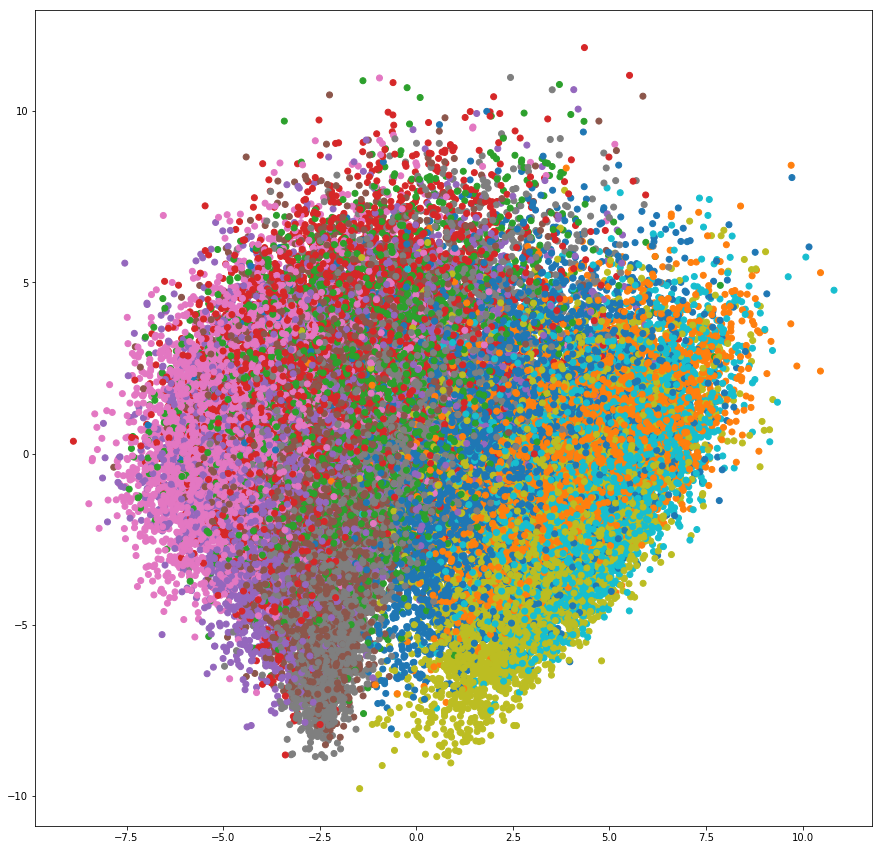

In [6]:
from matplotlib import pyplot as plt
plt.figure( figsize=(15,15) )
plt.scatter( X[:, 0], X[:, 1], c=y_training, cmap='tab10' )
# plt.colorbar()
plt.show()

## Feature analysis using t-SNE

In [14]:
from sklearn.manifold import TSNE
pca = decomposition.PCA(n_components=60)
X_training_reduced = pca.fit_transform(X_training)

Since t-SNE is quite complex, it is worth to compress the data. Let say that 56% is enough.

In [15]:
np.sum( pca.explained_variance_ratio_ )

0.5668

In [16]:
tsne = TSNE(n_components=2)

In [17]:
X_training_reduced_tsne = tsne.fit_transform(X_training_reduced)

In [19]:
X_training_reduced_tsne.shape

(50000, 2)

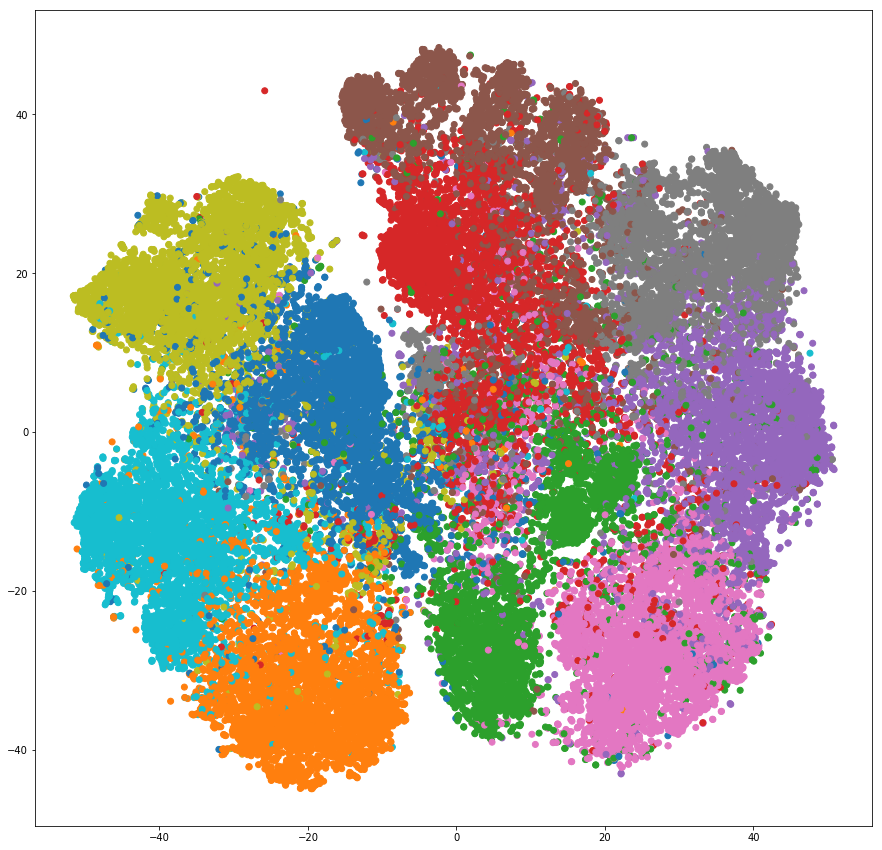

In [20]:
plt.figure( figsize=(15,15) )
plt.scatter( X_training_reduced_tsne[:, 0], X_training_reduced_tsne[:, 1], c=y_training, cmap='tab10' )
plt.show()

I think we can start to use Linear Classifier now :-)